In [ ]:
!npm install -g @anthropic-ai/claude-code

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
changed 3 packages in 6s
⠙
⠙2 packages are looking for funding
⠙  run `npm fund` for details
⠙

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fetching 5000 bars of BTC/USDT data for the 1h timeframe from Coinbase...
Fetched 300 bars so far...
Fetched 600 bars so far...
Fetched 900 bars so far...
Fetched 1200 bars so far...
Fetched 1500 bars so far...
Fetched 1800 bars so far...
Fetched 2100 bars so far...
Fetched 2400 bars so far...
Fetched 2700 bars so far...
Fetched 3000 bars so far...
Fetched 3300 bars so far...
Fetched 3600 bars so far...
Fetched 3900 bars so far...
Fetched 4200 bars so far...
Fetched 4500 bars so far...
Fetched 4800 bars so far...
Fetched 5000 bars so far...

Data fetched successfully! Total bars collected: 5000
Calculating MFTR indicator values...
MFTR calculation complete.

Final dataframe is 4930 rows long. Head:
                          open       high        low      close     volume  \
time                                                                         
2024-12-18 04:00:00  104695.76  104696.25  103557.49  103869.07   8.706437   
2024-12-18 05:00:00  103869.08  104126.09  103264.38  1034

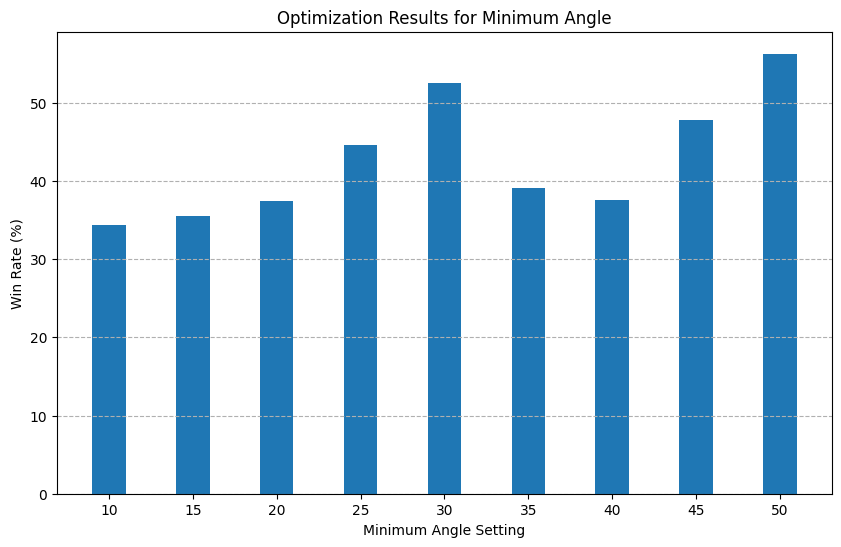

In [ ]:
# ==============================================================================
# MFTR Pro Analysis & Optimization Suite (v9 - Final)
# ==============================================================================
# This Google Colab notebook is a complete, self-contained system.
#
# It will:
# 1. Fetch extensive historical data using a robust, paginated method.
# 2. Re-implement the entire MFTR indicator logic in Python, including a
#    custom, self-contained ADX calculation to bypass Colab environment errors.
# 3. Perform advanced probability analysis and parameter optimization.
# ==============================================================================

# --- Step 1: Install and Upgrade Necessary Libraries ---
# We still need these for other functions, but the problematic DMI is now handled internally.
!pip install --upgrade numpy==1.23.5 pandas ccxt pandas_ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ccxt
import pandas_ta as ta
import time

# ==============================================================================
# --- Step 2: Fetch Historical Market Data ---
# ==============================================================================
def fetch_paginated_data(symbol='BTC/USDT', timeframe='1h', total_bars=5000):
    print(f"Fetching {total_bars} bars of {symbol} data for the {timeframe} timeframe from Coinbase...")
    try:
        exchange = ccxt.coinbase()
        limit_per_request = 300
        all_ohlcv = []
        timeframe_duration_in_ms = exchange.parse_timeframe(timeframe) * 1000
        since = exchange.milliseconds() - total_bars * timeframe_duration_in_ms
        while len(all_ohlcv) < total_bars:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit_per_request)
            if not ohlcv: break
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + timeframe_duration_in_ms
            print(f"Fetched {len(all_ohlcv)} bars so far...")
            time.sleep(exchange.rateLimit / 1000)
        df = pd.DataFrame(all_ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        df.drop_duplicates(subset='time', inplace=True)
        df.set_index('time', inplace=True)
        print(f"\nData fetched successfully! Total bars collected: {len(df)}")
        return df.sort_index()
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

df = fetch_paginated_data(symbol='BTC/USDT', timeframe='1h', total_bars=5000)

# ==============================================================================
# --- Step 3: Re-implement MFTR Indicator in Python ---
# ==============================================================================

# --- NEW: Self-Contained ADX Calculation ---
def calculate_adx(df, length=14):
    df['tr'] = ta.true_range(df['high'], df['low'], df['close'])
    df['up_move'] = df['high'].diff()
    df['down_move'] = -df['low'].diff()
    df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
    df['plus_di'] = 100 * (ta.ema(df['plus_dm'], length) / ta.ema(df['tr'], length))
    df['minus_di'] = 100 * (ta.ema(df['minus_dm'], length) / ta.ema(df['tr'], length))
    df['dx'] = 100 * (abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di']))
    df['adxValue'] = ta.ema(df['dx'], length)
    # Clean up intermediate columns
    df.drop(['tr', 'up_move', 'down_move', 'plus_dm', 'minus_dm', 'plus_di', 'minus_di', 'dx'], axis=1, inplace=True)
    return df

def calculate_mftr(df, **params):
    if df is None or df.empty:
        print("Cannot calculate MFTR. Dataframe is empty.")
        return None
    print("Calculating MFTR indicator values...")
    try:
        df.ta.rsi(length=params['N_rsi'], append=True)
        df.ta.atr(length=params['N_atr_ratio'], append=True)

        # FIXED: Using our new, self-contained ADX function
        df = calculate_adx(df, length=params['dmi_adx_length'])

        df['maValue'] = ta.kama(df['close'], length=params['kama_length'], fast=params['kama_fast'], slow=params['kama_slow'])
        df['priceRatio'] = (df['close'] - df['maValue']) / df[f'ATRr_{params["N_atr_ratio"]}']
        df['vwcbRaw'] = (df['close'] - df['open']) * df['volume']
        df['vwcbSmoothed'] = ta.ema(df['vwcbRaw'], length=params['N_vwcb_smooth'])
        df['deltaVolume'] = np.where(df['close'] > df['open'], df['volume'], np.where(df['close'] < df['open'], -df['volume'], 0))
        df['cvd'] = ta.sma(df['deltaVolume'], length=params['cvdLookback'])
        components_to_normalize = ['priceRatio', 'vwcbSmoothed', 'cvd']
        for comp in components_to_normalize:
            mean = df[comp].rolling(window=params['Normalization_Period']).mean()
            std = df[comp].rolling(window=params['Normalization_Period']).std()
            df[f'norm_{comp}'] = (df[comp] - mean) / std
        df['centered_rsi'] = df[f'RSI_{params["N_rsi"]}'] - 50
        df['mftrLineRaw'] = (df['norm_priceRatio'] * params['Scaling_Factor'] + df['norm_vwcbSmoothed'] * params['Scaling_Factor'] + df['norm_cvd'] * params['Scaling_Factor'] + df['centered_rsi'])
        df['mftrLine'] = ta.ema(df['mftrLineRaw'], length=params['N_mftr_smooth'])
        df['mftrSignal'] = ta.ema(df['mftrLine'], length=params['N_signal'])
        delta_y = df['mftrLine'] - df['mftrLine'].shift(1)
        df['angle'] = np.degrees(np.arctan(delta_y / 10))
        df.dropna(inplace=True)
        print("MFTR calculation complete.")
        return df
    except Exception as e:
        print(f"A critical error occurred during calculation: {e}")
        return None

default_params = {
    'kama_length': 10, 'kama_fast': 2, 'kama_slow': 30,
    'N_atr_ratio': 14, 'N_vwcb_smooth': 14,
    'cvdLookback': 21, 'N_rsi': 14, 'dmi_adx_length': 14,
    'Normalization_Period': 50, 'Scaling_Factor': 10.0,
    'N_mftr_smooth': 10, 'N_signal': 5
}

if df is not None:
    df_mftr = calculate_mftr(df.copy(), **default_params)
    if df_mftr is not None:
        print(f"\nFinal dataframe is {len(df_mftr)} rows long. Head:")
        print(df_mftr.head())

# ==============================================================================
# --- Function 1: Event-Based Probability Analysis ---
# ==============================================================================
def analyze_event_probability(df, min_adx=20, min_angle_event=40, look_forward_bars=20):
    if df is None: return
    print(f"\n--- Running Probability Analysis ---")
    print(f"Event: Crossover with ADX > {min_adx} and Angle > {min_angle_event}")
    print(f"Analyzing price change over the next {look_forward_bars} bars.")
    buy_signals = df[(df['mftrLine'] > df['mftrSignal']) & (df['mftrLine'].shift(1) < df['mftrSignal'].shift(1))]
    valid_buy_signals = buy_signals[(buy_signals['adxValue'] > min_adx) & (buy_signals['angle'] > min_angle_event)]
    price_changes = []
    for index, row in valid_buy_signals.iterrows():
        start_index = df.index.get_loc(index)
        if start_index + look_forward_bars < len(df):
            entry_price = row['close']
            exit_price = df.iloc[start_index + look_forward_bars]['close']
            percent_change = ((exit_price - entry_price) / entry_price) * 100
            price_changes.append(percent_change)
    if not price_changes:
        print("No valid buy signals found for the specified criteria.")
    else:
        average_change = np.mean(price_changes)
        win_rate = (np.sum(np.array(price_changes) > 0) / len(price_changes)) * 100
        print(f"\nFound {len(valid_buy_signals)} valid buy signals.")
        print(f"Average price change after {look_forward_bars} bars: {average_change:.2f}%")
        print(f"Win Rate (price was higher after {look_forward_bars} bars): {win_rate:.2f}%")

# ==============================================================================
# --- Function 2: Parameter Optimization (Parameter Sweep) ---
# ==============================================================================
def optimize_angle_parameter(df_original, min_adx=20, stop_loss_pct=2.0, take_profit_pct=4.0):
    if df_original is None: return
    print(f"\n--- Running Parameter Optimization for 'minAngle' ---")
    angle_range = range(10, 51, 5)
    results = {}
    for test_angle in angle_range:
        df = df_original.copy()
        wins = 0
        losses = 0
        buy_signals = df[(df['mftrLine'] > df['mftrSignal']) & (df['mftrLine'].shift(1) < df['mftrSignal'].shift(1))]
        valid_buy_signals = buy_signals[(buy_signals['adxValue'] > min_adx) & (buy_signals['angle'] > test_angle)]
        for index, row in valid_buy_signals.iterrows():
            entry_price = row['close']
            stop_loss_price = entry_price * (1 - stop_loss_pct / 100)
            take_profit_price = entry_price * (1 + take_profit_pct / 100)
            start_iloc = df.index.get_loc(index)
            for i in range(start_iloc + 1, len(df)):
                future_low = df.iloc[i]['low']
                future_high = df.iloc[i]['high']
                if future_low <= stop_loss_price:
                    losses += 1
                    break
                if future_high >= take_profit_price:
                    wins += 1
                    break
        total_trades = wins + losses
        win_rate = (wins / total_trades) * 100 if total_trades > 0 else 0
        results[test_angle] = win_rate
        print(f"Testing Angle: {test_angle}, Found {total_trades} trades, Win Rate: {win_rate:.2f}%")
    if results:
        plt.figure(figsize=(10, 6))
        plt.bar(results.keys(), results.values(), width=2)
        plt.xlabel("Minimum Angle Setting")
        plt.ylabel("Win Rate (%)")
        plt.title("Optimization Results for Minimum Angle")
        plt.xticks(list(results.keys()))
        plt.grid(axis='y', linestyle='--')
        plt.show()

# ==============================================================================
# --- Step 4: Run the Analysis ---
# ==============================================================================
if 'df_mftr' in locals() and df_mftr is not None:
    analyze_event_probability(df_mftr, min_adx=20, min_angle_event=40, look_forward_bars=24)
    optimize_angle_parameter(df_mftr, min_adx=20, stop_loss_pct=2.0, take_profit_pct=4.0)
else:
    print("\nSkipping analysis because data could not be fetched or processed.")